In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
import csv
import random
from statistics import mean

In [34]:
def loadData(filePath, inputVariableName, outputVariableName):
    data = pd.read_csv(filePath)
    
    inputIndex = data.columns.get_loc(inputVariableName)
    outputIndex = data.columns.get_loc(outputVariableName)
    
    inputs = data.iloc[:, inputIndex].values
    outputs = data.iloc[:, outputIndex].values
    
    return inputs, outputs


crtDir =  os.getcwd()
filePath = os.path.join(crtDir, 'data', 'world-happiness-report-2017.csv')

inputs, outputs = loadData(filePath, 'Economy..GDP.per.Capita.', 'Happiness.Score')
print("in: ", inputs[:5])
print("out: ", outputs[:5])

in:  [1.61646318 1.48238301 1.48063302 1.56497955 1.44357193]
out:  [7.53700018 7.52199984 7.50400019 7.49399996 7.46899986]


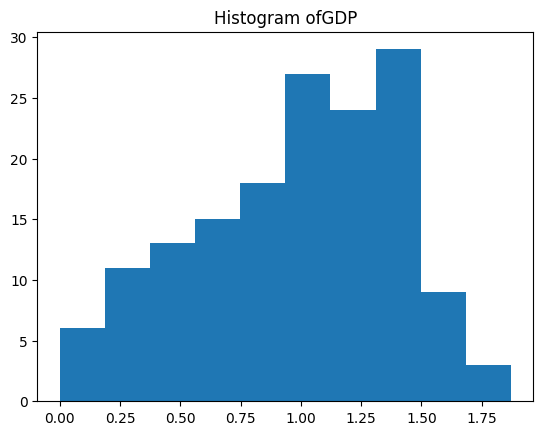

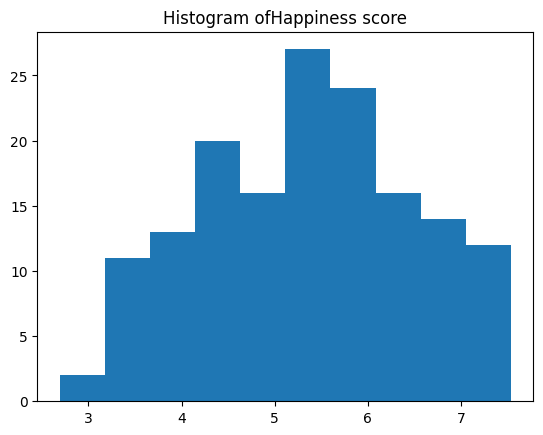

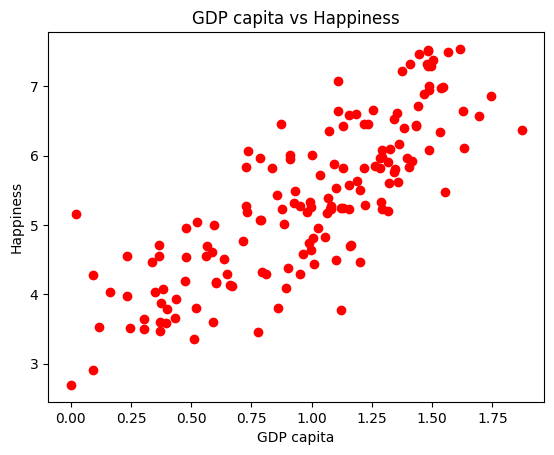

In [35]:
def plotDataHistogram(x, variableName):
    n, bins, patches = plt.hist(x, 10)
    plt.title("Histogram of" + variableName)
    plt.show()

plotDataHistogram(inputs, "GDP")
plotDataHistogram(outputs, "Happiness score")


def check_liniarity(inputs, outputs):
    plt.plot(inputs, outputs, "ro")
    plt.xlabel("GDP capita")
    plt.ylabel("Happiness")
    plt.title("GDP capita vs Happiness")
    plt.show()

check_liniarity(inputs, outputs)

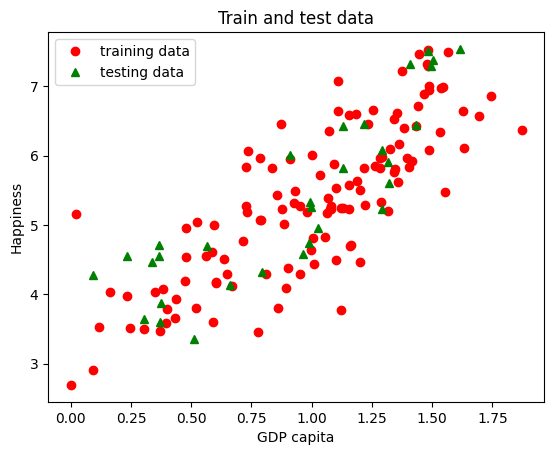

In [36]:
# Split the Data Into Training and Test Subsets (in proportion 80/20%)
def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]

    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]
    
    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    
    return trainInputs, trainOutputs, testInputs, testOutputs

trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)


def plotTrainTestData(trainInputs, trainOutputs, testInputs, testOutputs):
    plt.plot(trainInputs, trainOutputs, 'ro', label = 'training data')
    plt.plot(testInputs, testOutputs, 'g^', label = 'testing data')
    plt.title('Train and test data')
    plt.xlabel("GDP capita")
    plt.ylabel("Happiness")
    plt.legend()
    plt.show()

plotTrainTestData(trainInputs, trainOutputs, testInputs, testOutputs)

In [22]:
#batch gradient descent
class BGDRegression:
    def __init__(self):
        self.intercept_ = 0.0
        self.coef_ = []

    def fit(self, x, y, learningRate=0.001, noEpochs=1000, batchSize=20):
        self.coef_ = [random.random() for _ in range(len(x[0]) + 1)]
        n = len(x)
        for epoch in range(noEpochs):
            #shuffle the dataset
            indices = list(range(n))
            random.shuffle(indices)
            x = [x[i] for i in indices]
            y = [y[i] for i in indices]
            #iterate over batches
            for i in range(0, n, batchSize):
                x_batch = x[i:i + batchSize]
                y_batch = y[i:i + batchSize]
                errors = []
                for xi,yi in zip(x_batch, y_batch):
                    yComputed = self.eval(xi)
                    errors.append(yComputed - yi)
                error = mean(errors)
                for xi,yi in zip(x_batch, y_batch):
                    for j in range(len(xi)):
                        self.coef_[j] -= learningRate * error * xi[j]
                self.coef_[-1] -= learningRate * error
        self.intercept_ = self.coef_[-1]
        self.coef_ = self.coef_[:-1]

    def eval(self, xi):
        yi = self.coef_[-1]
        for j in range(len(xi)):
            yi += self.coef_[j] * xi[j]
        return yi

    def predict(self, x):
        yComputed = [self.eval(xi) for xi in x]
        return yComputed

the learnt model with tool: f(x) =  3.2618789830287374  +  2.2100367021141634  * x
the learnt model: f(x) =  0.9399307706923504  +  4.389949047542177  * x


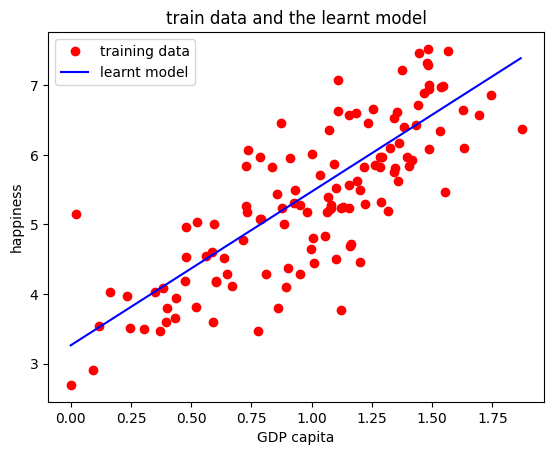

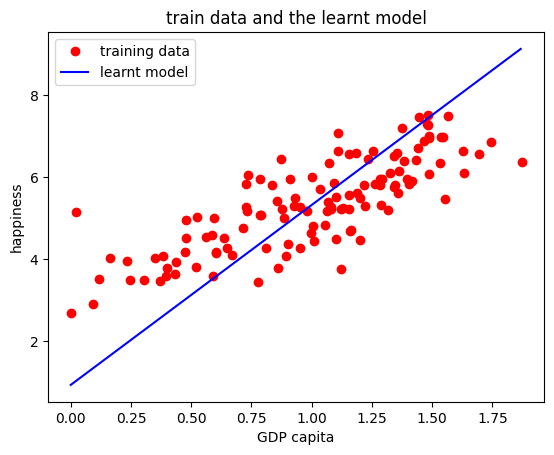

In [37]:
# learning step: init and train a linear regression model y = f(x) = w0 + w1 * x
# using sklearn
xx = [[el] for el in trainInputs]
regressor = SGDRegressor(loss='squared_error', penalty=None, learning_rate='constant', eta0=0.1)
regressor.fit(xx, trainOutputs)
w0, w1 = regressor.intercept_[0], regressor.coef_[0]
print('the learnt model with tool: f(x) = ', w0, ' + ', w1, ' * x')

# code by me
xx = [[el] for el in trainInputs]
regressor = BGDRegression()
regressor.fit(xx, trainOutputs)
b0, b1 = regressor.intercept_, regressor.coef_[0]
print('the learnt model: f(x) = ', b0, ' + ', b1, ' * x')

# plot the learnt model
# prepare some synthetic data (inputs are random, while the outputs are computed by the learnt model)
def plotModel(trainInputs, trainOutputs, w0, w1):
    noOfPoints = 1000
    xref = []
    val = min(trainInputs)
    step = (max(trainInputs) - min(trainInputs)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [w0 + w1 * el for el in xref] 
    
    plt.plot(trainInputs, trainOutputs, 'ro', label = 'training data')
    plt.plot(xref, yref, 'b-', label = 'learnt model')
    plt.title('train data and the learnt model')
    plt.xlabel('GDP capita')
    plt.ylabel('happiness')
    plt.legend()
    plt.show()

plotModel(trainInputs, trainOutputs, w0, w1)
plotModel(trainInputs, trainOutputs, b0, b1)

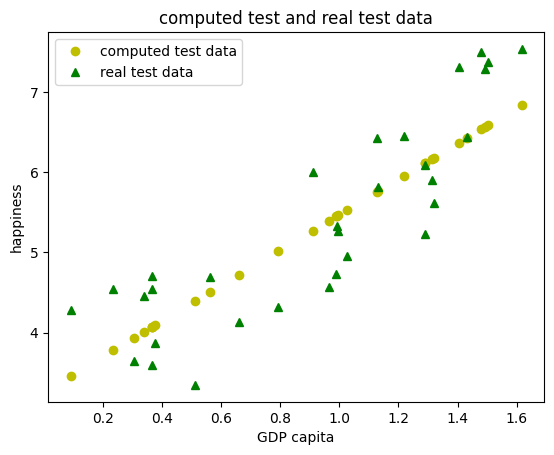

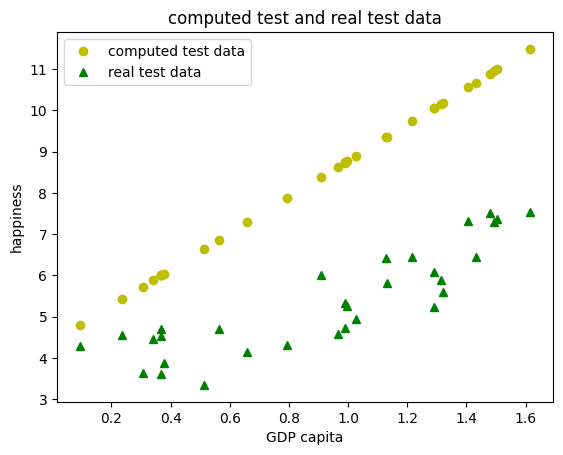

In [38]:
# use the trained model to predict new inputs

# makes predictions for test data (manual)
computedTestOutputsTool = [w0 + w1 * el for el in testInputs]
# makes predictions for test data (by tool)
computedTestOutputs = regressor.predict([[x] for x in testInputs])


# plot the computed outputs (see how far they are from the real outputs)
def plotPredictions(testInputs, testOutputs, computedTestOutputs):
    plt.plot(testInputs, computedTestOutputs, 'yo', label = 'computed test data')
    plt.plot(testInputs, testOutputs, 'g^', label = 'real test data')
    plt.title('computed test and real test data')
    plt.xlabel('GDP capita')
    plt.ylabel('happiness')
    plt.legend()
    plt.show()

plotPredictions(testInputs, testOutputs, computedTestOutputsTool)
plotPredictions(testInputs, testOutputs, computedTestOutputs)

In [39]:
def mse(computed, real):
    error = 0.0
    for y1, y2 in zip(computed, real):
        error += (y1 - y2) ** 2
    error /= len(real)
    return error

In [40]:
#compute the differences between the predictions and real outputs
# "manual" computation
error = mse(computedTestOutputs, testOutputs)
print('prediction error (manual): ', error)

# by using sklearn 
from sklearn.metrics import mean_squared_error

error = mean_squared_error(testOutputs, computedTestOutputs)
print('prediction error (tool):  ', error)

prediction error (manual):  10.614987050691125
prediction error (tool):   10.614987050691125


In [41]:
 def loadDataMoreInputs(fileName, inputVariabNames, outputVariabName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1
    selectedVariable1 = dataNames.index(inputVariabNames[0])
    selectedVariable2 = dataNames.index(inputVariabNames[1])
    inputs = [[float(data[i][selectedVariable1]), float(data[i][selectedVariable2])] for i in range(len(data))]
    selectedOutput = dataNames.index(outputVariabName)
    outputs = [float(data[i][selectedOutput]) for i in range(len(data))]
    
    return inputs, outputs

In [42]:
def plot3D(xTrain=None, yTrain=None, zTrain=None, xModel=None, yModel=None, zModel=None, xTest=None, yTest=None, zTest=None, title=None):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    if xTrain:
        ax.scatter(xTrain, yTrain, zTrain, label='training data', c='r', marker='o')
    if xModel:
        ax.scatter(xModel, yModel, zModel, c='b', marker='_', label='learnt model')
    if xTest:
        ax.scatter(xTest, yTest, zTest, c='g', marker='^', label='test data')
    ax.set_xlabel("GDP per capita")
    ax.set_ylabel("Freedom")
    ax.set_zlabel("Happiness")
    if title is not None:
        ax.set_title(title)
    ax.legend()
    plt.show()

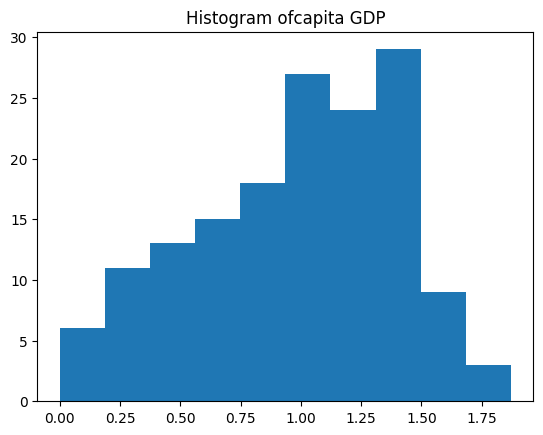

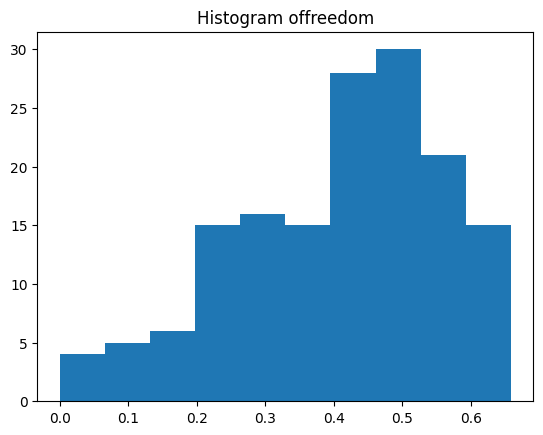

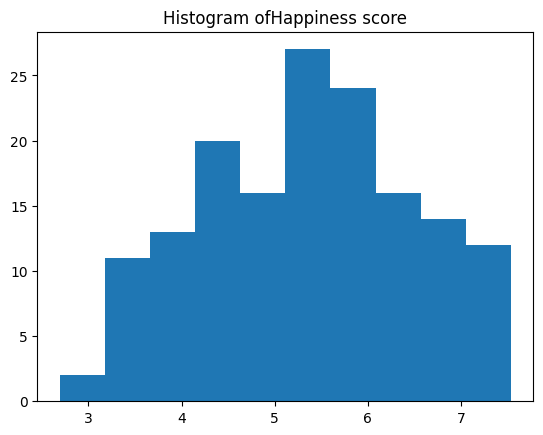

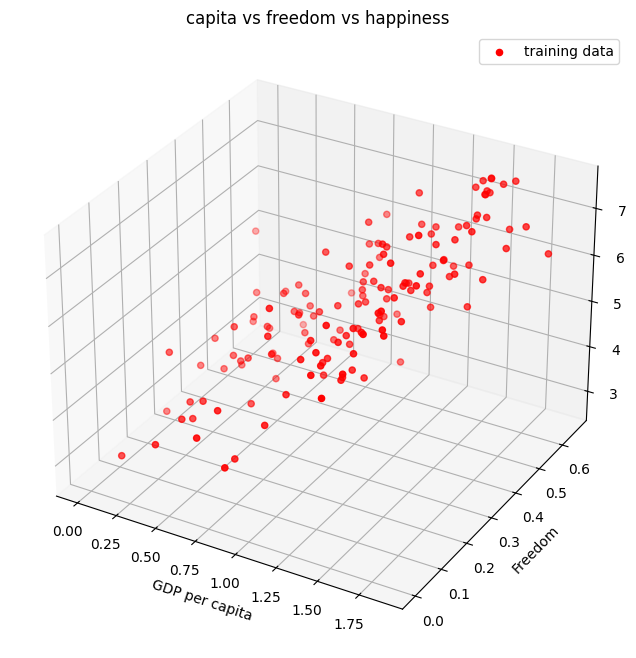

In [43]:
crtDir =  os.getcwd()
filePath = os.path.join(crtDir, 'data', 'world-happiness-report-2017.csv')

inputs, outputs = loadDataMoreInputs(filePath, ['Economy..GDP.per.Capita.', 'Freedom'], 'Happiness.Score')

feature1 = [ex[0] for ex in inputs]
feature2 = [ex[1] for ex in inputs]

# plot the data histograms
plotDataHistogram(feature1, 'capita GDP')
plotDataHistogram(feature2, 'freedom')
plotDataHistogram(outputs, 'Happiness score')

# check the liniarity
plot3D(feature1, feature2, outputs, [], [], [], [], [], [], 'capita vs freedom vs happiness')

In [44]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        #encode each sample into a list
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]
        
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
        
        #decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
    return normalisedTrainData, normalisedTestData

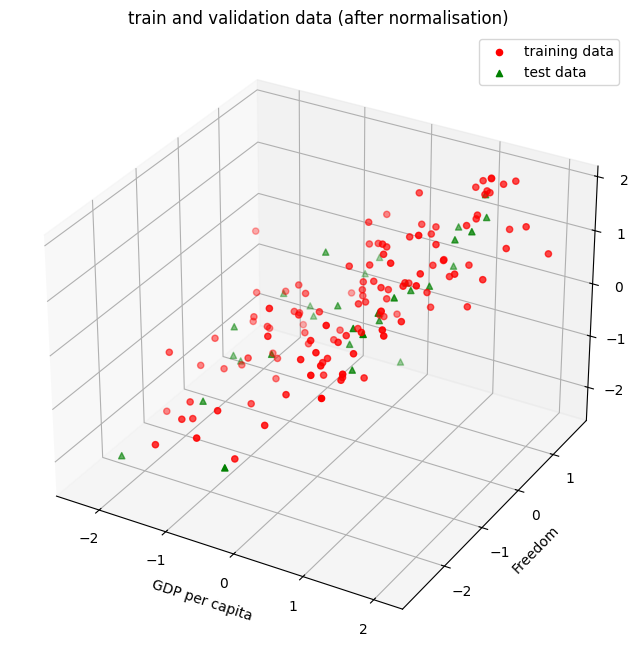

In [45]:
# Split the Data Into Training and Test Subsets(80/20%)
np.random.seed(8)
indexes = [i for i in range(len(inputs))]
trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace=False)
testSample = [i for i in indexes if i not in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]

testInputs = [inputs[i] for i in testSample]
testOutputs = [outputs[i] for i in testSample]


trainInputs, testInputs = normalisation(trainInputs, testInputs)
trainOutputs, testOutputs = normalisation(trainOutputs, testOutputs)
feature1train = [x[0] for x in trainInputs]
feature2train = [x[1] for x in trainInputs]
feature1test = [x[0] for x in testInputs]
feature2test = [x[1] for x in testInputs]

plot3D(feature1train, feature2train, trainOutputs, [], [], [], feature1test, feature2test, testOutputs, 
           "train and validation data (after normalisation)")

the learnt model (tool): f(x) = -0.21016796834303647 + 0.7061869531830421 * x1 + 0.43324414372446246 * x2
the learnt model: f(x) =  0.00017280349846121603  +  0.6915461144256737  * x1 +  0.32178666642035086  * x2


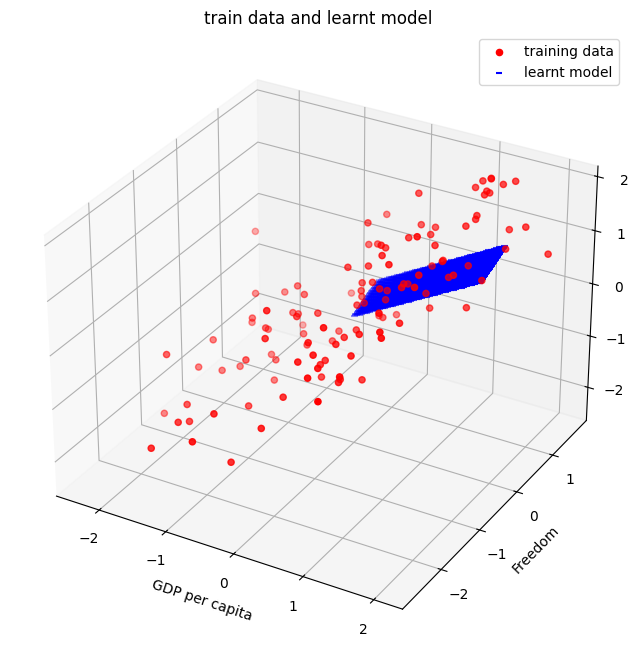

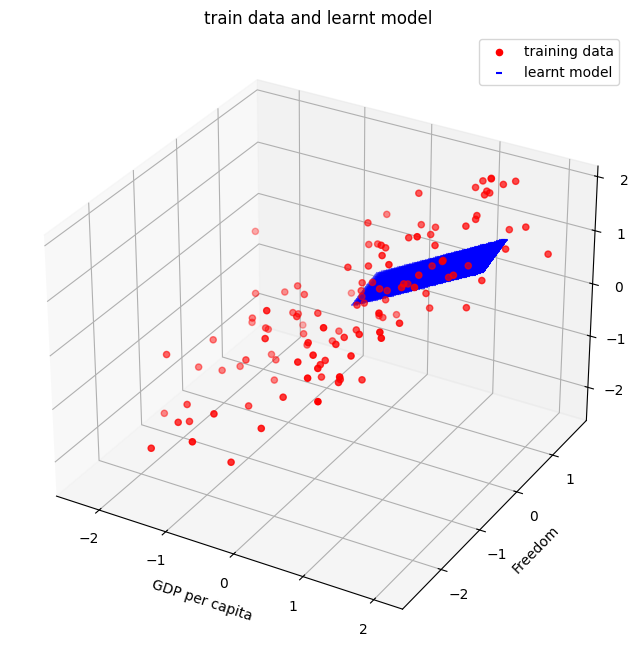

In [46]:
# identify (by training) the regressor

# use sklearn regressor
from sklearn import linear_model
regressor_tool = linear_model.SGDRegressor(loss='squared_error', penalty=None, learning_rate='constant', eta0=0.1)
regressor_tool.fit(trainInputs, trainOutputs)
w0, w1, w2 = regressor_tool.intercept_[0], regressor_tool.coef_[0], regressor_tool.coef_[1]
print('the learnt model (tool): f(x) =', w0, '+', w1, '* x1', '+', w2, '* x2')

# using code by me
regressor = BGDRegression()
regressor.fit(trainInputs, trainOutputs)
b0, b1, b2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]
print('the learnt model: f(x) = ', b0, ' + ', b1, ' * x1 + ', b2, ' * x2' )


def plotModelMoreInputs(trainInputs, trainOutputs, w0, w1, w2):
    noOfPoints = 50
    xref = []
    val = min(feature1)
    step1 = (max(feature1) - min(feature1)) / noOfPoints
    for _ in range(1, noOfPoints):
        for _ in range(1, noOfPoints):
            xref.append(val)
        val += step1

    yref = []
    val = min(feature2)
    step2 = (max(feature2) - min(feature2)) / noOfPoints
    for _ in range(1, noOfPoints):
        aux = val
        for _ in range(1, noOfPoints):
            yref.append(aux)
            aux += step2
    zref = [w0 + w1 * el1 + w2 * el2 for el1, el2 in zip(xref, yref)]
    plot3D(feature1train, feature2train, trainOutputs, xref, yref, zref, [], [], [], "train data and learnt model")
    
plotModelMoreInputs(trainInputs, trainOutputs, w0, w1, w2)
plotModelMoreInputs(trainInputs, trainOutputs, b0, b1, b2)

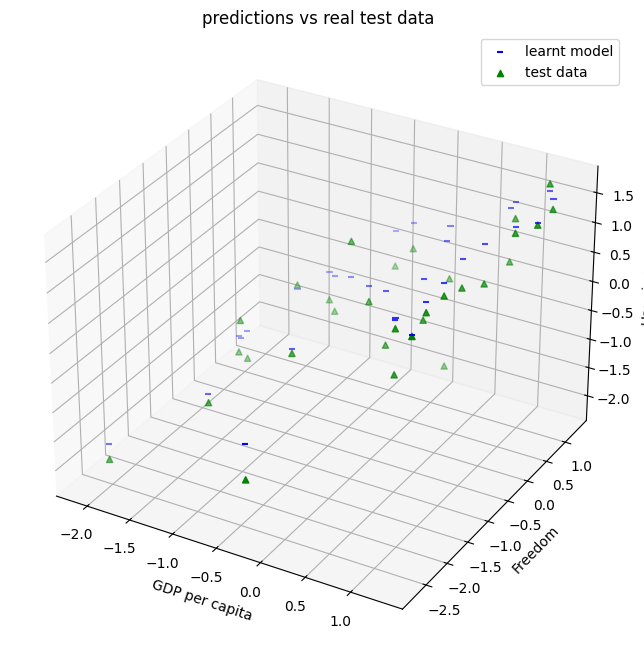

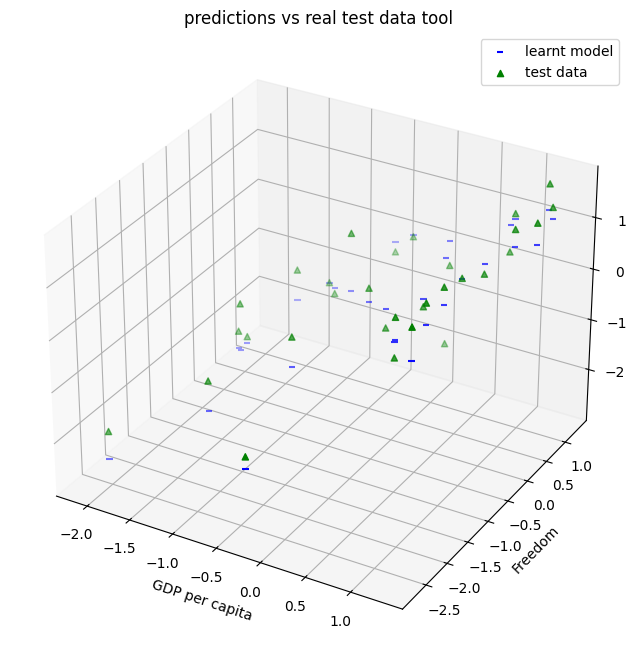

prediction error (manual):  0.38298881831344306
prediction error (tool):   0.38298881831344306


In [47]:
# use the trained model to predict new inputs
computedTestOutputs = regressor.predict(testInputs)
plot3D([], [], [], feature1test, feature2test, computedTestOutputs, feature1test, feature2test, testOutputs, "predictions vs real test data")

computedTestOutputsTool = regressor_tool.predict(testInputs)
plot3D([], [], [], feature1test, feature2test, computedTestOutputsTool, feature1test, feature2test, testOutputs, "predictions vs real test data tool")


# compute the differences between the predictions and real outputs
error = mse(computedTestOutputs, testOutputs)
print('prediction error (manual): ', error)

from sklearn.metrics import mean_squared_error
error = mean_squared_error(testOutputs, computedTestOutputs)
print('prediction error (tool):  ', error)